In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
from sFLD import *
from calculate_error import *

In [68]:
# get data ready

In [69]:
e_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/Esun.csv"
l_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/Lo_spectrum_inclF.csv"
f_pathname = "/Users/jameswallace/Desktop/Project/data/verification_run_2021-06-14-1239/fluorescence_scalars.csv"
# place the spectra in readable dataframes
e_df = get_simulated_spectral_df(e_pathname)
l_df = get_simulated_spectral_df(l_pathname)
f_df = pd.read_csv(f_pathname)
f_df = f_df.iloc[1:]
# get the O2A fluorescence from the fluorescence scalars df
f_761 = pd.to_numeric(f_df['F761'])
# now average them for every ten rows
e_average = average_dataframe(e_df, 10)
l_average = average_dataframe(l_df, 10)
f_average = average_dataframe(f_761, 10)

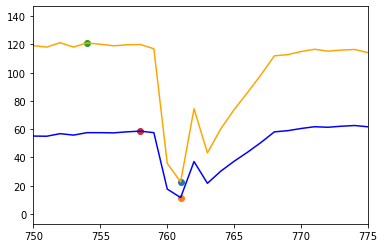

0.6750198110058563

In [70]:
new_sFLD(np.asarray(e_average.iloc[0]) /np.pi, np.asarray(l_average.iloc[0]), np.arange(400, 2562), plot = True)

In [71]:
# apply the new sFLD method to each row of the averaged simulated data
differences = []
percentage_errors = []
for i in range(len(e_average)):
    error = f_average[i] - new_sFLD(np.asarray(e_average.iloc[i]) / np.pi, np.asarray(l_average.iloc[i]), np.arange(400, 2562), plot = False)
    error = np.sqrt(error**2)
    differences.append(error)
    percentage_errors.append(100*(error) / f_average[i])

# calculate average percentage error
np.mean(percentage_errors)

17.649736205230447

In [90]:
def three_FLD(e_spectra, l_spectra, wavelengths, plot=True):
    
    buffer_in = 1
    buffer_out = 8
    
    wl_in = 760
    
    # get absorption well position
    e_in_index, e_in = stats_on_spectra(wavelengths, wl_in - buffer_in, wl_in + buffer_in, e_spectra, 'min')
    l_in_index, l_in = stats_on_spectra(wavelengths, wl_in - buffer_in, wl_in + buffer_in, l_spectra, 'min')
    
    # get absorption shoulders
    e_left_index, e_left = stats_on_spectra(wavelengths, wl_in - buffer_in, wl_in, e_spectra, 'max')
    l_left_index, l_left = stats_on_spectra(wavelengths, wl_in - buffer_in, wl_in, l_spectra, 'max')
    
    e_right_index, e_right = stats_on_spectra(wavelengths, wl_in, wl_in + buffer_out, e_spectra, 'max')
    l_right_index, l_right = stats_on_spectra(wavelengths, wl_in, wl_in + buffer_out, l_spectra, 'max')
    
    # interpolate between shoulders
    
    e_wavelengths_inter = wavelengths[e_left_index:e_right_index + 1]
    l_wavelengths_inter = wavelengths[l_left_index:l_right_index + 1]
    
    # get equation of straight line between two shoulders
    
    e_xp = [e_wavelengths_inter[0], e_wavelengths_inter[-1]] # get x values
    l_xp = [l_wavelengths_inter[0], l_wavelengths_inter[-1]]
    
    e_fp = [e_left, e_right] # get y values
    l_fp = [l_left, l_right]
    
    e_coefficients = np.polyfit(e_xp, e_fp, 1) # polyfit for equation
    l_coefficients = np.polyfit(l_xp, l_fp, 1)
    
    # apply to wavelengths in between shoulders
    
    e_interpolated = e_wavelengths_inter*e_coefficients[0] + e_coefficients[1]
    l_interpolated = l_wavelengths_inter*l_coefficients[0] + l_coefficients[1]
    
    # find interpolated value inside of absorption band
    
    e_out = e_interpolated[e_in_index - e_left_index]
    l_out = l_interpolated[l_in_index - l_left_index]
    
    
    if plot == True:
        
        # plot spectra
        plt.plot(wavelengths, e_spectra, color = 'orange')
        plt.plot(wavelengths, l_spectra, color = 'blue')
        
        # plot selected points
        plt.scatter(wavelengths[e_in_index], e_in, label = 'e_in')
        plt.scatter(wavelengths[l_in_index], l_in, label = 'l_in')
        plt.scatter(wavelengths[e_left_index], e_left, label = 'e_left')
        plt.scatter(wavelengths[l_left_index], l_left, label = 'l_left')
        plt.scatter(wavelengths[e_right_index], e_right, label = 'e_right')
        plt.scatter(wavelengths[l_right_index], l_right, label = 'l_right')
        
        # plot interpolation
        plt.plot(e_wavelengths_inter, e_interpolated)
        plt.plot(l_wavelengths_inter, l_interpolated)
        plt.scatter(wavelengths[e_in_index], e_out, label = 'e_out')
        plt.scatter(wavelengths[l_in_index], l_out, label = 'l_out')
        
        #plt.legend()
        plt.xlim(750, 775)
        plt.show()
    
    fluorescence = (e_out*l_in - l_out*e_in) / (e_out - e_in)
    
    return(fluorescence)

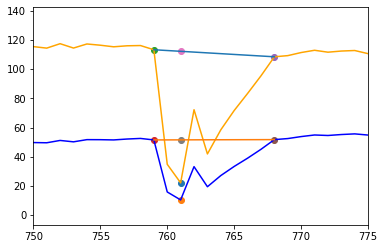

0.2504011015845598

In [91]:
three_FLD(np.asarray(e_average.iloc[1]) /np.pi, np.asarray(l_average.iloc[1]), np.arange(400, 2562), plot = True)

In [93]:
# apply the new sFLD method to each row of the averaged simulated data
differences = []
percentage_errors = []
for i in range(len(e_average)):
    error = f_average[i] - three_FLD(np.asarray(e_average.iloc[i]) / np.pi, np.asarray(l_average.iloc[i]), np.arange(400, 2562), plot = False)
    differences.append(error)
    percentage_error = 100*abs(error) / (f_average[i])
    percentage_errors.append(percentage_error)

# calculate average percentage error
np.mean(percentage_errors)

65.49013752396516